In [418]:
from numpy import array as npa
import numpy as np
import math
import pymatgen
import sys

#Import VasprunClass
from pymatgen.io.vasp.outputs import Procar, Vasprun
from pymatgen.core import Structure
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.plotter import DosPlotter

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec

def rgbline(ax, k, e, red, green, blue, KPOINTS, alpha=1.):
    #creation of segments based on
    #http://nbviewer.ipython.org/urls/raw.github.com/dpsanders/matplotlib-examples/master/colorline.ipynb
    pts = np.array([KPOINTS, e]).T.reshape(-1, 1, 2)
    seg = np.concatenate([pts[:-1], pts[1:]], axis=1)
    nseg = len(KPOINTS) -1
    r = [0.5*(red[i]+red[i+1]) for i in range(nseg)]
    g = [0.5*(green[i]+green[i+1]) for i in range(nseg)]
    b = [0.5*(blue[i]+blue[i+1]) for i in range(nseg)]
    a = np.ones(nseg, np.float)*alpha
    lc = LineCollection(seg, colors=tuple(zip(r,g,b,a)), linewidth = 2)
    ax.add_collection(lc)


# !!!!!!!!!!!! MANUAL INPUT NEEDED !!!!!!!!!!!!!!!!!!
# File needed
# working directory
work_dir = "/home/zheting/vasp/scripts/testdata/mag/relax_position/1/"

# POSCAR structure
POSCAR_struct = work_dir + "./band/POSCAR"

# vasprun.xml for band and dos 
Vasprun_band = work_dir + "./band/vasprun.xml"
Vasprun_dos = work_dir + "./dos/vasprun.xml"

# KPOINTS for band
KPOINTS_band = work_dir + "./band/KPOINTS"

# PROCAR for band
PROCAR_band = work_dir + "./band/PROCAR"

# POTCAR
# This is automatic but make sure you have it at work_dir + "./dos/"

# PROCAR for initial calculation
PROCAR_init = work_dir + "./PROCAR"

bands_K = Vasprun(Vasprun_band)
structure = Structure.from_file(POSCAR_struct)
bands = Vasprun(Vasprun_band).get_band_structure(KPOINTS_band, line_mode = True)

# projected bands
data = Procar(PROCAR_band).data

# Input Fermi energy 
# Efermi = 4.6844

In [419]:
contrib = np.zeros((len(bands.kpoints), bands.nb_bands, 3))
# sum up atomic contributions and normalize contributions
weight = np.power(data[Spin.up], 2)
indices = [[],[],[]]
for i in range(len(bands.structure.species)):
    if str(bands.structure.species[i]) == "O":
        indices[0].append(i)
    if str(bands.structure.species[i]) == "Cu":
        indices[1].append(i)
    if str(bands.structure.species[i]) == "Bi":
        indices[2].append(i)
print("Atom indices are ", indices)

for i in range(len(indices)):
    contrib[:,:,i] = np.sum(np.sum(weight[:,:,indices[i],0:8], axis=3), axis=2)

tot = np.sum(contrib, axis=2)
for b in range(bands.nb_bands):
    for k in range(len(bands.kpoints)):
        if tot[k, b] != 0.0:
            contrib[k, b, :] = contrib[k, b, :]/tot[k, b]

reciprocal = bands.lattice_rec.matrix/(2*math.pi)

KPOINTS = [0.0]
DIST = 0.0
# Create list with distances between Kpoints (Individual), corrects the spacing
for k in range(len(bands.kpoints)-1 ):
    Dist = np.subtract(bands.kpoints[k+1].frac_coords,bands.kpoints[k].frac_coords)
    DIST += np.linalg.norm(np.dot(reciprocal,Dist))
    KPOINTS.append(DIST)


Atom indices are  [[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27]]


/mnt/d/ubuntu/software/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


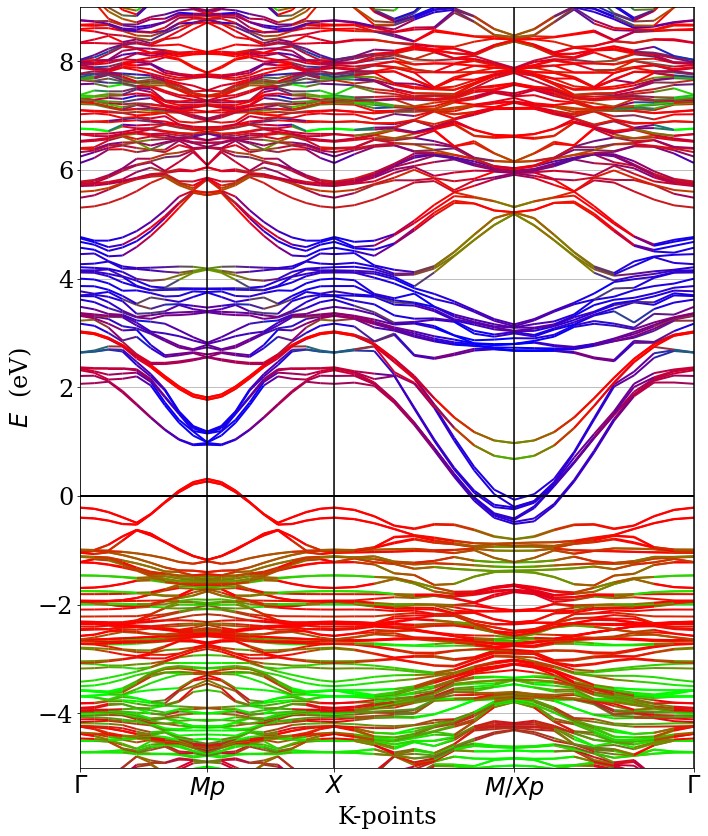

In [420]:
# Number of points between kpoints, found in the KPOINTS file
step = 10

# general options for plot
font = {'family': 'serif', 'size': 24}
plt.rc('font', **font)

gs = GridSpec(1, 1)
fig = plt.figure(figsize=(11.0, 14.0))
ax1 = plt.subplot(gs[0])

# set ylim for the plot
# ---------------------
emin = -5
emax = 9
ax1.set_ylim(emin, emax)
# plot bands using rgb mapping
for b in range(bands.nb_bands):
    rgbline(ax1,
            range(len(bands.kpoints)),
            [e - bands.efermi for e in bands.bands[Spin.up][b]],
            contrib[:,b,0],
            contrib[:,b,1],
            contrib[:,b,2],
            KPOINTS)

# style
ax1.set_xlabel("K-points")
ax1.set_ylabel(r"$E$  (eV)")
ax1.grid()

# fermi level at 0
ax1.hlines(y=0, xmin=0, xmax=len(bands.kpoints), color="k", lw=2)

TICKS = [0.0]
for i in range(step,len(KPOINTS)+step,step):
    ax1.vlines(KPOINTS[i-1], emin, emax, "k")
    TICKS.append(KPOINTS[i-1])
ax1.set_xticks(TICKS)
# labels of high-symmetry KPOINTS
# labels=[u"$\\Gamma$", u"$X$", u"$M$", u"$\\Gamma$"]
labels=[u"$\\Gamma$", u"$Mp$", u"$X$", u"$M/Xp$", u"$\\Gamma$"]
# labels=[u"$\\Gamma$", u"$Mp$", u"$X$", u"$M/Xp$", u"$\\Gamma$", u"$Z$", u"$Mp(Z)$", u"$X(Z)$", u"$M/Xp(Z)$", u"$Z$"]
ax1.set_xticklabels(labels)

ax1.set_xlim(0, KPOINTS[-1])
# Plotting 
# -----------------
plt.savefig(work_dir+"band_up.pdf", format="pdf")

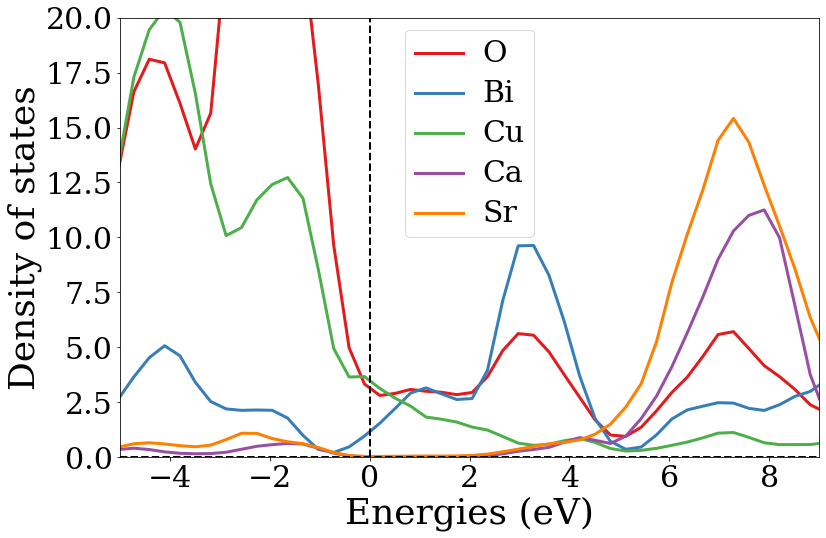

In [257]:
# Density of states
# -----------------
# density of states
dosrun = Vasprun(Vasprun_dos)
cdos = dosrun.complete_dos
element_dos = cdos.get_element_dos()
# spd_dos = cdos.get_spd_dos()
plotter = DosPlotter()
plotter.add_dos_dict(element_dos)
# plotter.show(xlim=[-8, 10], ylim=[0, 10])

# Plotting 
# -----------------
plotter.save_plot(filename=work_dir+"dos.pdf", img_format="pdf", xlim=[-5, 9], ylim=[0, 20])


Summing Densities of State
Sr (1 of 60)
Summing Densities of State
Sr (2 of 60)
Summing Densities of State
Sr (3 of 60)
Summing Densities of State
Sr (4 of 60)
Summing Densities of State
Sr (5 of 60)
Summing Densities of State
Sr (6 of 60)
Summing Densities of State
Sr (7 of 60)
Summing Densities of State
Sr (8 of 60)
Summing Densities of State
Ca (9 of 60)
Summing Densities of State
Ca (10 of 60)
Summing Densities of State
Ca (11 of 60)
Summing Densities of State
Ca (12 of 60)
Summing Densities of State
Cu (13 of 60)
Summing Densities of State
Cu (14 of 60)
Summing Densities of State
Cu (15 of 60)
Summing Densities of State
Cu (16 of 60)
Summing Densities of State
Cu (17 of 60)
Summing Densities of State
Cu (18 of 60)
Summing Densities of State
Cu (19 of 60)
Summing Densities of State
Cu (20 of 60)
Summing Densities of State
Bi (21 of 60)
Summing Densities of State
Bi (22 of 60)
Summing Densities of State
Bi (23 of 60)
Summing Densities of State
Bi (24 of 60)
Summing Densities of Stat

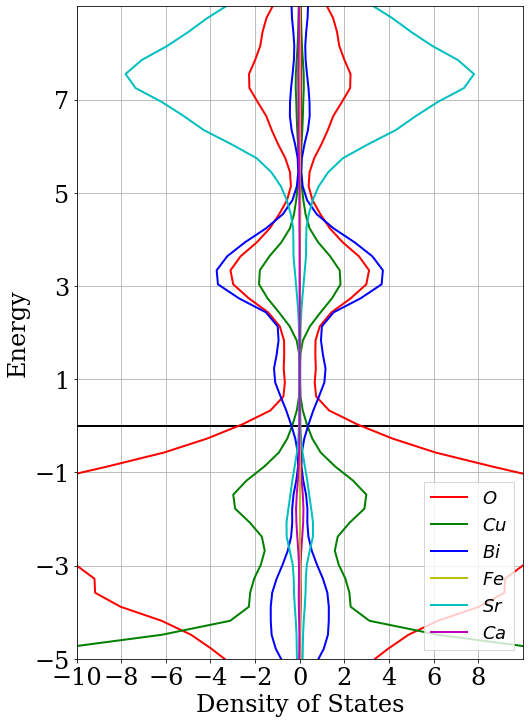

In [402]:
# Density of states
# -----------------
# density of states
dosrun = Vasprun(Vasprun_dos)
gs = GridSpec(1, 1)
fig = plt.figure(figsize=(8.0, 12.0))
ax2 = plt.subplot(gs[0])
ax2.grid()
dosrange = 10
ax2.set_xticks(np.arange(-dosrange, dosrange, 2))
ax2.set_xlim(-dosrange,dosrange)
emax = 9
emin = -5
ax2.set_yticks(np.arange(emin, emax, 2))
ax2.set_ylim(emin, emax)
ax2.hlines(y=0, xmin=-dosrange, xmax=dosrange, color="k", lw=2)
ax2.set_xlabel("Density of States")
ax2.set_ylabel("Energy")
# ax2.set_yticklabels([])

# atom contribution
spinlist = [Spin.up, Spin.down]
ssign = [1, -1]
DOS = [[],[]]
for s in range(2):
    ispin = spinlist[s]
    for i in range(7):
        DOS[s].append(np.zeros(len(dosrun.pdos[0][Orbital.s][ispin])))   
    
for i in range(len(bands.structure.species)):
    print("Summing Densities of State")
    print(str(bands.structure.species[i]) + " (" + str(i + 1) + " of " + str(len(bands.structure.species)) + ")")
    for s in range(2):
        ispin = spinlist[s]
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "O":
            DOS[s][0] += ssign[s] * (npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) )
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Cu":
            DOS[s][1] += ssign[s] * (npa(dosrun.pdos[i][Orbital.dxy][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dxz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dyz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dx2][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dz2][ispin]) )
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Bi":
            DOS[s][2] += ssign[s] * (npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]))
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Fe":
            DOS[s][3] += ssign[s] * (npa(dosrun.pdos[i][Orbital.dxy][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dxz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dyz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dx2][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dz2][ispin]) )
            DOS[s][6] += ssign[s] * (npa(dosrun.pdos[i][Orbital.s][ispin]))
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Sr":
            DOS[s][4] += ssign[s] * (npa(dosrun.pdos[i][Orbital.s][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dxy][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dxz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dyz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dx2][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dz2][ispin]) )
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Ca":
            DOS[s][5] += ssign[s] * (npa(dosrun.pdos[i][Orbital.s][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) )

# Plot Labels
# for s in range(2):
#     ispin = spinlist[s]
ax2.plot(DOS[0][0],dosrun.tdos.energies - dosrun.efermi, \
        "r-", label = "$O$", linewidth = 2)
ax2.plot(DOS[0][1],dosrun.tdos.energies - dosrun.efermi, \
        "g-", label = "$Cu$", linewidth = 2)
ax2.plot(DOS[0][2],dosrun.tdos.energies - dosrun.efermi, \
        "b-", label = "$Bi$", linewidth = 2)
ax2.plot(DOS[0][3],dosrun.tdos.energies - dosrun.efermi, \
        "y-", label = "$Fe$", linewidth = 2)
ax2.plot(DOS[0][4],dosrun.tdos.energies - dosrun.efermi, \
        "c-", label = "$Sr$", linewidth = 2)
ax2.plot(DOS[0][5],dosrun.tdos.energies - dosrun.efermi, \
        "m-", label = "$Ca$", linewidth = 2)
ax2.plot(DOS[1][0],dosrun.tdos.energies - dosrun.efermi, \
        "r-", linewidth = 2)
ax2.plot(DOS[1][1],dosrun.tdos.energies - dosrun.efermi, \
        "g-", linewidth = 2)
ax2.plot(DOS[1][2],dosrun.tdos.energies - dosrun.efermi, \
        "b-", linewidth = 2)
ax2.plot(DOS[1][3],dosrun.tdos.energies - dosrun.efermi, \
        "y-", linewidth = 2)
ax2.plot(DOS[1][4],dosrun.tdos.energies - dosrun.efermi, \
        "c-", linewidth = 2)
ax2.plot(DOS[1][5],dosrun.tdos.energies - dosrun.efermi, \
        "m-", linewidth = 2)
#     ax2.fill_between(ssign[s] * dosrun.tdos.densities[ispin],
#         0,
#         dosrun.tdos.energies - dosrun.efermi,
#         color = (0.7, 0.7, 0.7),
#         facecolor = (0.7, 0.7, 0.7))

#     ax2.plot(ssign[s] * dosrun.tdos.densities[ispin],
#         dosrun.tdos.energies - dosrun.efermi,
#         color = (0.6, 0.6, 0.6),
#         label = "Total")
ax2.legend(fancybox=False, shadow=False, prop={'size': 18},loc=4)

# Plotting 
# -----------------
plt.savefig(work_dir+"dos_mine.pdf", format="pdf")

Summing Densities of State
Sr (1 of 31)
Summing Densities of State
Sr (2 of 31)
Summing Densities of State
Sr (3 of 31)
Summing Densities of State
Sr (4 of 31)
Summing Densities of State
Ca (5 of 31)
Summing Densities of State
Ca (6 of 31)
Summing Densities of State
Cu (7 of 31)
Summing Densities of State
Cu (8 of 31)
Summing Densities of State
Cu (9 of 31)
Summing Densities of State
Cu (10 of 31)
Summing Densities of State
Bi (11 of 31)
Summing Densities of State
Bi (12 of 31)
Summing Densities of State
Bi (13 of 31)
Summing Densities of State
Bi (14 of 31)
Summing Densities of State
O (15 of 31)
Summing Densities of State
O (16 of 31)
Summing Densities of State
O (17 of 31)
Summing Densities of State
O (18 of 31)
Summing Densities of State
O (19 of 31)
Summing Densities of State
O (20 of 31)
Summing Densities of State
O (21 of 31)
Summing Densities of State
O (22 of 31)
Summing Densities of State
O (23 of 31)
Summing Densities of State
O (24 of 31)
Summing Densities of State
O (25 of

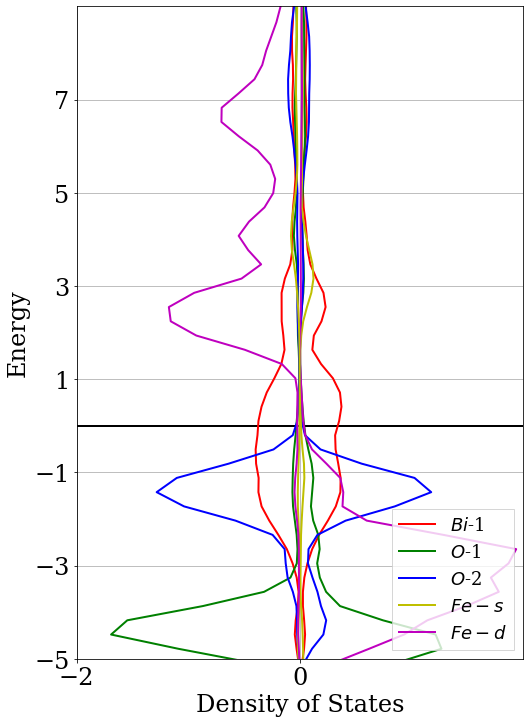

In [245]:
# Density of states of relaxed atoms
# -----------------
dosrun = Vasprun(Vasprun_dos)
gs = GridSpec(1, 1)
fig = plt.figure(figsize=(8.0, 12.0))
ax2 = plt.subplot(gs[0])
ax2.grid()
dosrange = 2
ax2.set_xticks(np.arange(-dosrange, dosrange, 2))
ax2.set_xlim(-dosrange,dosrange)
emax = 9
emin = -5
ax2.set_yticks(np.arange(emin, emax, 2))
ax2.set_ylim(emin, emax)
ax2.hlines(y=0, xmin=-dosrange, xmax=dosrange, color="k", lw=2)
ax2.set_xlabel("Density of States")
ax2.set_ylabel("Energy")
# ax2.set_yticklabels([])

# atom contribution
spinlist = [Spin.up, Spin.down]
ssign = [1, -1]
DOS = [[],[]]
for s in range(2):
    ispin = spinlist[s]
    for i in range(5):
        DOS[s].append(np.zeros(len(dosrun.pdos[0][Orbital.s][ispin])))   
    
for i in range(len(bands.structure.species)):
    print("Summing Densities of State")
    print(str(bands.structure.species[i]) + " (" + str(i + 1) + " of " + str(len(bands.structure.species)) + ")")
    for s in range(2):
        ispin = spinlist[s]
        ### CUSTOM ATOM CHOICES
        if i == 13:
            DOS[s][0] += ssign[s] * (npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) )
        ### CUSTOM ATOM CHOICES
        if i == 22:
            DOS[s][1] += ssign[s] * (npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) )
        ### CUSTOM ATOM CHOICES
        if i == 27:
            DOS[s][2] += ssign[s] * (npa(dosrun.pdos[i][Orbital.px][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.py][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.pz][ispin]) )
        ### CUSTOM ATOM CHOICES
        if str(bands.structure.species[i]) == "Fe":
            DOS[s][3] += ssign[s] * (npa(dosrun.pdos[i][Orbital.s][ispin]))
            DOS[s][4] += ssign[s] * (npa(dosrun.pdos[i][Orbital.dxy][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dxz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dyz][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dx2][ispin]) + \
                     npa(dosrun.pdos[i][Orbital.dz2][ispin]) )

# Plot Labels
# for s in range(2):
#     ispin = spinlist[s]
ax2.plot(DOS[0][0],dosrun.tdos.energies - dosrun.efermi, \
        "r-", label = "$Bi$-1", linewidth = 2)
ax2.plot(DOS[0][1],dosrun.tdos.energies - dosrun.efermi, \
        "g-", label = "$O$-1", linewidth = 2)
ax2.plot(DOS[0][2],dosrun.tdos.energies - dosrun.efermi, \
        "b-", label = "$O$-2", linewidth = 2)
ax2.plot(DOS[0][3],dosrun.tdos.energies - dosrun.efermi, \
        "y-", label = "$Fe-s$", linewidth = 2)
ax2.plot(DOS[0][4],dosrun.tdos.energies - dosrun.efermi, \
        "m-", label = "$Fe-d$", linewidth = 2)
ax2.plot(DOS[1][0],dosrun.tdos.energies - dosrun.efermi, \
        "r-", linewidth = 2)
ax2.plot(DOS[1][1],dosrun.tdos.energies - dosrun.efermi, \
        "g-", linewidth = 2)
ax2.plot(DOS[1][2],dosrun.tdos.energies - dosrun.efermi, \
        "b-", linewidth = 2)
ax2.plot(DOS[1][3],dosrun.tdos.energies - dosrun.efermi, \
        "y-", linewidth = 2)
ax2.plot(DOS[1][4],dosrun.tdos.energies - dosrun.efermi, \
        "m-", linewidth = 2)
#     ax2.fill_between(ssign[s] * dosrun.tdos.densities[ispin],
#         0,
#         dosrun.tdos.energies - dosrun.efermi,
#         color = (0.7, 0.7, 0.7),
#         facecolor = (0.7, 0.7, 0.7))

#     ax2.plot(ssign[s] * dosrun.tdos.densities[ispin],
#         dosrun.tdos.energies - dosrun.efermi,
#         color = (0.6, 0.6, 0.6),
#         label = "Total")
ax2.legend(fancybox=False, shadow=False, prop={'size': 18},loc=4)

# Plotting 
# -----------------
plt.savefig(work_dir+"dos_relaxed.pdf", format="pdf")

In [149]:
# read file
procar_data = Procar(PROCAR_init)

# name of orbitals
orbs = ["s","px","py","pz","dxy","dxz","dyz","dx2","dz2"]
norbs = len(orbs)

# get the total number of atoms
natom = len(bands.structure.species)
print("There are", natom, "atoms")

# get occupation numbers of each atoms
occ = np.zeros(natom)
occ_isolate = np.zeros(natom)
atom_occ = []
for i in range(natom):
    print("Atom No.", i+1, str(bands.structure.species[i]))
    atom_occ.append(np.zeros([2,norbs]))
    atom_occ[i][0,:] = np.array([procar_data.get_occupation(i,orbs[iorb])[Spin.up] for iorb in range(norbs)])
    atom_occ[i][1,:] = np.array([procar_data.get_occupation(i,orbs[iorb])[Spin.down] for iorb in range(norbs)])
    print("  Orbital occupation numbers: ")
    print("  s orbital", atom_occ[i][:,0])
    print("  p orbital", atom_occ[i][:,1:4])
    print("  d orbital", atom_occ[i][:,4:])
    
    occ[i] = np.sum(atom_occ[i])
    
#     # identify original occupation number of each atom
#     if str(bands.structure.species[i]) == "Sr":
#         occ_isolate[i] = 10
#         occ[i] = np.sum(atom_occ[:,0:4])
#     if str(bands.structure.species[i]) == "Ca":
#         occ_isolate[i] = 10
#         occ[i] = np.sum(atom_occ[:,0:4])
#     if str(bands.structure.species[i]) == "Cu":
#         occ_isolate[i] = 17
#         occ[i] = np.sum(atom_occ[:,:])
#     if str(bands.structure.species[i]) == "Bi":
#         occ_isolate[i] = 5
#         occ[i] = np.sum(atom_occ[:,0:4])
#     if str(bands.structure.species[i]) == "O":
#         occ_isolate[i] = 6
#         occ[i] = np.sum(atom_occ[:,0:4])
#     if str(bands.structure.species[i]) == "Fe":
#         occ_isolate[i] = 14
#         occ[i] = np.sum(atom_occ[:,:])
    
print(" ")
print("Total occupancies are", occ)
print("Total occupancies changes are", occ-oldocc)
# print("Total occupancies are", occ_isolate-occ)


    
    

There are 31 atoms
Atom No. 1 Sr
  Orbital occupation numbers: 
  s orbital [1.2157501  1.21372232]
  p orbital [[1.03102786 1.03155564 1.04555564]
 [1.02908342 1.02969453 1.03994453]]
  d orbital [[0.63166672 0.61877783 0.61927783 0.59561116 0.60102783]
 [0.62955561 0.61563894 0.61633338 0.59372227 0.59652783]]
Atom No. 2 Sr
  Orbital occupation numbers: 
  s orbital [1.21638899 1.21586121]
  p orbital [[1.02761119 1.02705564 1.04408342]
 [1.0267223  1.02644453 1.03966675]]
  d orbital [[0.62772227 0.61491672 0.61519449 0.59538894 0.59811116]
 [0.62783338 0.61400005 0.6130556  0.59363894 0.59463894]]
Atom No. 3 Sr
  Orbital occupation numbers: 
  s orbital [1.22013899 1.21708343]
  p orbital [[1.03288897 1.03252786 1.04486119]
 [1.03177786 1.03205564 1.03788897]]
  d orbital [[0.63008338 0.61266672 0.61336116 0.59897227 0.60033338]
 [0.62905561 0.6120556  0.61225005 0.59763894 0.5985556 ]]
Atom No. 4 Sr
  Orbital occupation numbers: 
  s orbital [1.21947232 1.21608343]
  p orbital [[1

In [148]:
oldocc = np.append(oldocc, 0)

In [140]:
oldocc = occ
oldatom_occ = atom_occ

In [159]:
np.sum(occ-oldocc)-18.16366812

7.8463292976299925

In [207]:
dosrun.pdos[13]

defaultdict(dict,
            {<Orbital.s: 0>: {<Spin.up: 1>: array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
                     0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e

In [130]:
np.sum(np.array([[1,2],[2,3]]))

8

In [344]:
bands.efermi

4.36174278

In [296]:
i = Orbital.dx2
dosrun.pdos[15][i]

{<Spin.up: 1>: array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000

In [44]:

min(np.array([1,2,3]),np.array([2,3,1]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
list_a = np.array([1, 2, 3])
list_b = np.array([3,2,1])
ind = list_a > list_b
list_a[ind] = list_b[ind]
list_a

array([1, 2, 1])

In [159]:
dosrun = Vasprun(Vasprun_dos)

<Figure size 841.68x1099.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

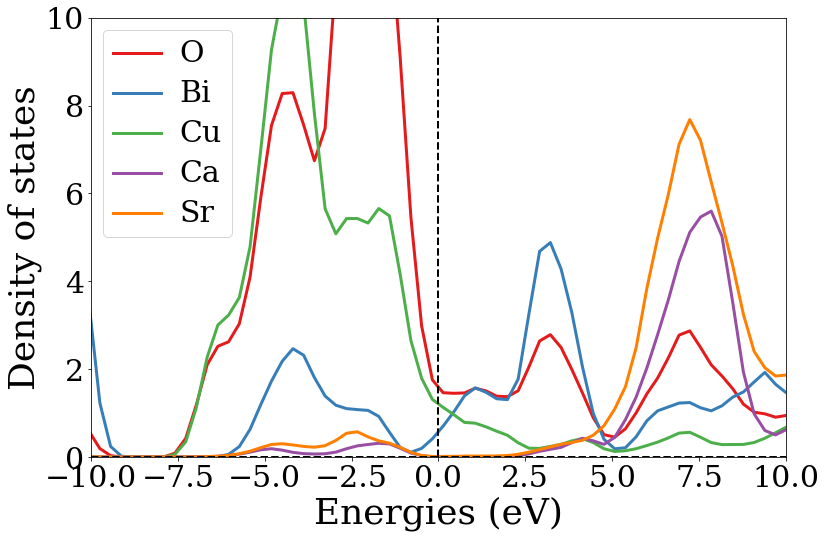

In [160]:
# set up 2 graph with aspec ratio 2/1
# plot 1: bands diagram
# plot 2: Density of States
#    fig.suptitle("BN\textsubscript{2} Monolayer")
ax1 = plt.figure(figsize=(11.69, 15.27))
ax2 = plt.figure(figsize=(11.69, 8.27))
# Density of states
# -----------------
# density of states

cdos = dosrun.complete_dos
element_dos = cdos.get_element_dos()
# spd_dos = cdos.get_spd_dos()
plotter = DosPlotter()
plotter.add_dos_dict(element_dos)
ax2 = plotter.show(xlim=[-10, 10], ylim=[0, 10])

In [110]:
from numpy import array as npa
import numpy as np
import math
import pymatgen
import sys

from pymatgen.io.vasp.outputs import Procar, Vasprun
from pymatgen.core import Structure
from pymatgen.electronic_structure.core import Spin, Orbital

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec

def rgbline(ax, k, e, red, green, blue, KPOINTS, alpha=1.):
    #creation of segments based on
    #http://nbviewer.ipython.org/urls/raw.github.com/dpsanders/matplotlib-examples/master/colorline.ipynb
    pts = np.array([KPOINTS, e]).T.reshape(-1, 1, 2)
    seg = np.concatenate([pts[:-1], pts[1:]], axis=1)
    nseg = len(KPOINTS) -1
    r = [0.5*(red[i]+red[i+1]) for i in range(nseg)]
    g = [0.5*(green[i]+green[i+1]) for i in range(nseg)]
    b = [0.5*(blue[i]+blue[i+1]) for i in range(nseg)]
    a = np.ones(nseg, np.float64)*alpha
    lc = LineCollection(seg, colors=tuple(zip(r,g,b,a)), linewidth = 2)
    ax.add_collection(lc)

In [131]:
# Load Structure
structure = Structure.from_file(POSCAR_struct)
# Load Band Structure Calculations
bands_K = Vasprun(Vasprun_band)

# Load Band Structure Calculations
bands = bands_K.get_band_structure(KPOINTS_band, line_mode = False)

# projected bands
data = Procar(PROCAR_band).data


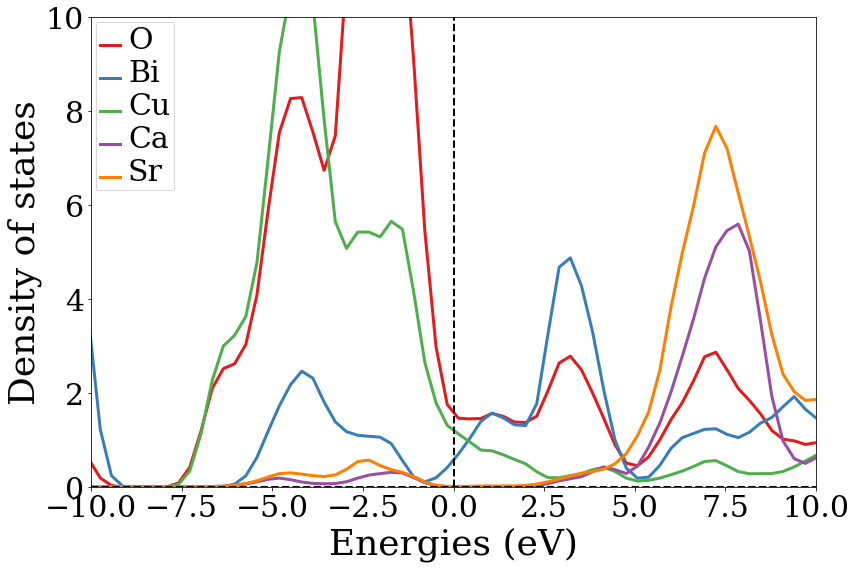

In [137]:
%matplotlib inline
from pymatgen.io.vasp import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter

v = Vasprun(Vasprun_dos)
cdos = v.complete_dos
element_dos = cdos.get_element_dos()
# spd_dos = cdos.get_spd_dos()
plotter = DosPlotter()
plotter.add_dos_dict(element_dos)
plotter.show(xlim=[-10, 10], ylim=[0, 10])

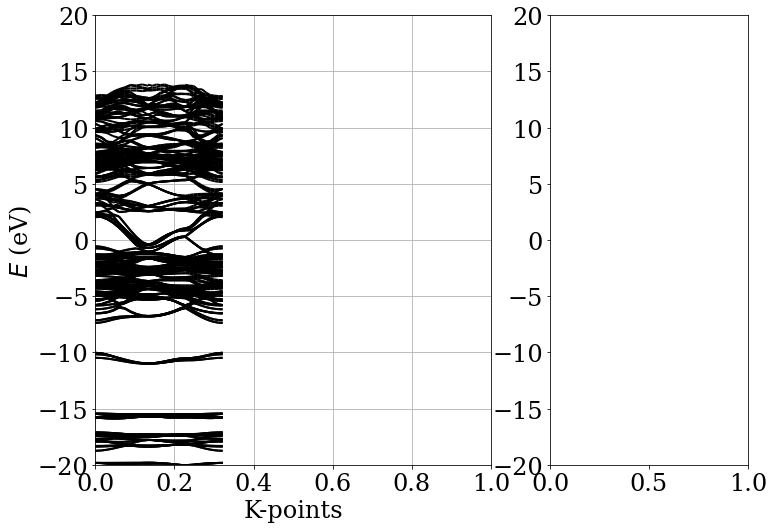

In [138]:
# general options for plot
font = {'family': 'serif', 'size': 24}
plt.rc('font', **font)

# set up 2 graph with aspec ratio 2/1
# plot 1: bands diagram
# plot 2: Density of States
gs = GridSpec(1, 2, width_ratios=[2,1])
fig = plt.figure(figsize=(11.69, 8.27))
ax1 = plt.subplot(gs[0])

ax2 = plt.subplot(gs[1]) #, sharey=ax1)

# set ylim for the plot
# ---------------------
emin = 1e100
emax = -1e100

# Set both fermi levels equal to the dos fermi level
bands.efermi =  dosrun.efermi #= 0

for spin in bands.bands.keys():
    for b in range(bands.nb_bands):
        emin = min(emin, min(bands.bands[spin][b]))
        emax = max(emax, max(bands.bands[spin][b]))

emin -= bands.efermi + 1
emax -= bands.efermi - 1
emin = -20
emax = 20
ax1.set_ylim(emin, emax)
ax2.set_ylim(emin, emax)

# makes an empty list with the length of the number of bands and kpoints
contrib = np.zeros(( bands.nb_bands, len(bands.kpoints), 3))
# sum up atomic contributions and normalize contributions
# Sum over all bands
for b in range(bands.nb_bands):
    # Sum over all K-Points
    for k in range(len(bands.kpoints)):
        s = 0
        py_px = 0
        pz = 0
        # Sum over all atoms
        for i in range(len(bands.structure.species)):
            # Sum over the orbitals
            # Select which atom type they belong to
            # 0:s 1:py 2:pz 3:px 4:dxy 5:dyz 6:dz2 7:dxz 8:dx2_y2 
            for j in range(0,8,1):
                if j == 0:
                    s += data[Spin.up][k][b][i][j]**2
                if j == 1 or j == 3:
                    py_px += data[Spin.up][k][b][i][j]**2
                if j == 2:
                    pz += data[Spin.up][k][b][i][j]**2
                
        tot = s + py_px + pz

#         # Sum over for some elements
#         elements_list = np.unique(bands.structure.species)
#         elements_to_plot = elements_list[2:]
#         elements_to_plot_data = {}
#         tot = [0, 0]
#         for i in range(len(bands.structure.species)):
#             if bands.structure.species[i] in elements_to_plot:
#                 ielement = bands.structure.species[i]
#             else:
#                 continue
#             # Sum over the orbitals
#             # Select which atom type they belong to
#             # 0:s 1:py 2:pz 3:px 4:dxy 5:dyz 6:dz2 7:dxz 8:dx2_y2 
#             tempdata = [0, 0]
# #             for j in range(len(data[Spin.up][k][b][i])):
#             for j in range(8):
#                 tempdata[0] += data[Spin.up][k][b][i][j]**2
#                 tempdata[1] += data[Spin.down][k][b][i][j]**2
#             elements_to_plot_data[ielement] = tempdata
#             tot = [tot[x]+tempdata[x] for x in range(2)]
        
#         for s in range(2):
#             if tot[s] != 0.0:
#                 count = 0
#                 for ie in elements_to_plot:
#                     contrib[s, b, k, count] = elements_to_plot_data[ie][s] / tot[s]

reciprocal = bands.lattice_rec.matrix/(2*math.pi)

# Empty lists used for caculating the distances between K-Points
KPOINTS = [0.0]
DIST = 0.0
# Create list with distances between Kpoints (Individual), corrects the spacing
for k in range(len(bands.kpoints)-1):
    Dist = np.subtract(bands.kpoints[k+1].frac_coords,bands.kpoints[k].frac_coords)
    DIST += np.linalg.norm(np.dot(reciprocal,Dist))
    KPOINTS = np.append(KPOINTS, DIST)

# plot bands using rgb mapping
for b in range(bands.nb_bands):
    rgbline(ax1,
            range(len(bands.kpoints)),
            [e - bands.efermi for e in bands.bands[Spin.up][b]],
            contrib[b,:,0],
            contrib[b,:,1],
            contrib[b,:,2],
            KPOINTS)

# style
ax1.set_xlabel("K-points")
ax1.set_ylabel(r"$E$ (eV)")
ax1.grid()

/mnt/d/ubuntu/software/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


TypeError: object of type 'zip' has no len()

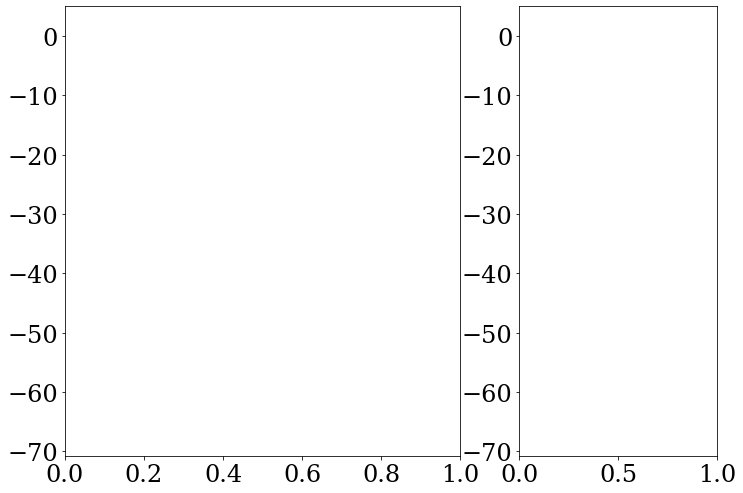

In [42]:

# fermi level line at 0
ax1.hlines(y=0, xmin=0, xmax=len(bands.kpoints), color="k", lw=2)

TICKS = [0.0]
for i in range(step,len(KPOINTS)+step,step):
    ax1.vlines(KPOINTS[i-1], emin, emax, "k")
    TICKS.append(KPOINTS[i-1])
ax1.set_xticks(TICKS)
ax1.set_xticklabels(labels)

ax1.set_xlim(0, KPOINTS[-1])

# Density of states
# -----------------

ax2.set_yticklabels([])
ax2.grid()
ax2.set_xticks(np.arange(0, 3.5, 1.5))
ax2.set_xlim(0,3.5)
ax2.hlines(y=0, xmin=0, xmax=3.5, color="k", lw=2)
ax2.set_xlabel("Density of States")

# atom contribution
# Zero NP arrays
s_dos = np.zeros(len(dosrun.pdos[0][Orbital.s][Spin.up]))
py_px_dos = np.zeros(len(dosrun.pdos[0][Orbital.s][Spin.up]))
pz_dos = np.zeros(len(dosrun.pdos[0][Orbital.s][Spin.up]))

# Sum over atoms
for i in range(len(bands.structure.species)):
    # Print Progress Labels
    print("Summing Densities of State")
    print(str(bands.structure.species[i]) + " (" + str(i + 1) + " of " + str(len(bands.structure.species)) + ")")

    s_dos += npa(dosrun.pdos[i][Orbital.s][Spin.up])
    py_px_dos += npa(dosrun.pdos[i][Orbital.px][Spin.up]) + \
             npa(dosrun.pdos[i][Orbital.py][Spin.up])
    pz_dos += npa(dosrun.pdos[i][Orbital.pz][Spin.up])
ax2.plot(s_dos,dosrun.tdos.energies - dosrun.efermi, \
        "r-", label = "$s$", linewidth = 2)
ax2.plot(py_px_dos,dosrun.tdos.energies - dosrun.efermi, \
        "g-", label = "$p_x + p_y$", linewidth = 2)
ax2.plot(pz_dos,dosrun.tdos.energies - dosrun.efermi, \
        "b-", label = "$p_z$", linewidth = 2)
ax2.fill_between(dosrun.tdos.densities[Spin.up],
    0,
    dosrun.tdos.energies - dosrun.efermi,
    color = (0.7, 0.7, 0.7),
    facecolor = (0.7, 0.7, 0.7))

ax2.plot(dosrun.tdos.densities[Spin.up],
    dosrun.tdos.energies - dosrun.efermi,
    color = (0.6, 0.6, 0.6),
    label = "Total")
ax2.legend(fancybox=False, shadow=False, prop={'size': 18},loc=4)

# Plotting 
# -----------------
plt.savefig(sys.argv[0].strip(".py") + ".pdf", format="pdf")

